In [82]:
#%matplotlib notebook
from pprint import pprint
from utils import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
plt.style.use('default')
from cycler import cycler
color_cycle = cycler(color=['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000'])

SOFT_RED, SOFT_BLUE = '#ffe5e5', '#e5e5ff' 

plt.rcParams['axes.prop_cycle'] = color_cycle
from datetime import datetime
import numpy as np 
import itertools

EYETRACKER_NAME = "EyeTracker:0"
EYETRACKERSTUB_NAME = "EyeTrackerStub"

TARGET_NAME = "Target:0"
WINDOW_SIZE = (800,800)
TRACKING_WINDOW_PROPERTIES = {'position': np.array((351.25, 37.85)), 'size': np.array((341.25, 341.25)), 'color':'red'}
FUEL_WINDOW_PROPERTIES = {'position': np.array((253.75, 455.71428571428567)), 'size': np.array((536.25, 334.2857142857143)), 'color':'blue'}
SYSTEM_WINDOW_PROPERTIES = {'position': np.array((10.0, 37.857142857142854)), 'size': np.array((243.75, 390.0)), 'color':'green'}
img = mpimg.imread('./images/background.png') # background image

# sanity check
#plt.figure()
#plt.imshow(img)
#plt.gca().add_patch(plt.Rectangle(TRACKING_WINDOW_PROPERTIES['position'], *TRACKING_WINDOW_PROPERTIES['size'], color='red', fill=False))
#plt.gca().add_patch(plt.Rectangle(FUEL_WINDOW_PROPERTIES['position'], *FUEL_WINDOW_PROPERTIES['size'], color='red', fill=False))
#plt.gca().add_patch(plt.Rectangle(SYSTEM_WINDOW_PROPERTIES['position'], *SYSTEM_WINDOW_PROPERTIES['size'], color='red', fill=False))

In [9]:
datasets = create_datasets(n=5)
# prune dataset to contain only those with valid eyetracking data...
#dataset = {k:data for k, data in dataset.items() if LineData.contains_source(data, EYETRACKER_NAME)}
#dataset = list(sorted([(k,v) for k,v in dataset.items()], key=lambda x: x[0][:3]))
#dataset = {k:list(g) for k,g in itertools.groupby(dataset, key=lambda x: x[0][:3])}

print(datasets.keys())
del datasets['000test.txt']

loading files...: 5it [00:01,  2.89it/s]

dict_keys(['000test.txt', 'P00icuA.txt', 'P00icuB.txt', 'P00icuaA.txt', 'P00icuaB.txt'])


TASK: P00icuA
Proportion spent gazing at system task    : 0.080
Proportion spent gazing at fuel task      : 0.265
Proportion spent gazing at tracking task  : 0.163
Proportion spent gazing at no task        : 0.017
Proportion spent gazing                   : 0.526
Switched task: 123 times (no re-entry)


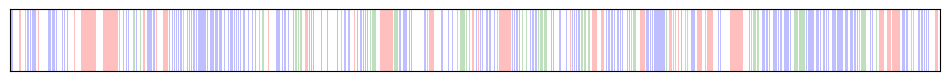

TASK: P00icuB
Proportion spent gazing at system task    : 0.138
Proportion spent gazing at fuel task      : 0.178
Proportion spent gazing at tracking task  : 0.204
Proportion spent gazing at no task        : 0.010
Proportion spent gazing                   : 0.531
Switched task: 135 times (no re-entry)


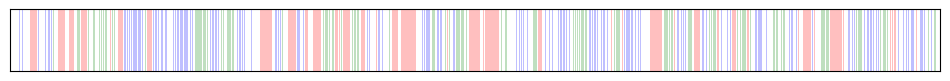

TASK: P00icuaA
Proportion spent gazing at system task    : 0.085
Proportion spent gazing at fuel task      : 0.233
Proportion spent gazing at tracking task  : 0.171
Proportion spent gazing at no task        : 0.004
Proportion spent gazing                   : 0.492
Switched task: 142 times (no re-entry)


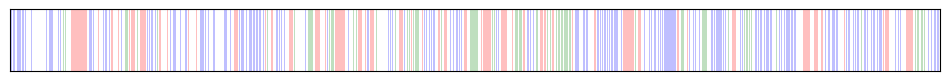

TASK: P00icuaB
Proportion spent gazing at system task    : 0.173
Proportion spent gazing at fuel task      : 0.190
Proportion spent gazing at tracking task  : 0.153
Proportion spent gazing at no task        : 0.004
Proportion spent gazing                   : 0.521
Switched task: 112 times (no re-entry)


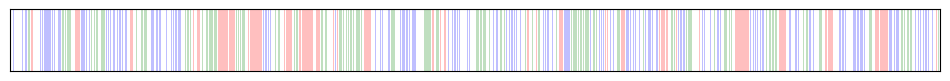

In [183]:
# TODO remove this is old now!

# gaze statistics
def in_box(x, y, pos, size):
    interval_x = (pos[0], pos[0] + size[0])
    interval_y = (pos[1], pos[1] + size[1])
    xok = np.logical_and(x > interval_x[0], x < interval_x[1])
    yok = np.logical_and(y > interval_y[0], y < interval_y[1])
    return np.logical_and(xok, yok)
    
for k,dataset in datasets.items():
    print(f"TASK: {k.split('.')[0]}")
    # official start/finish times
    _start_time, _finish_time = LineData.get_start_time(dataset), LineData.get_finish_time(dataset)
    
    eye_data = np.array(LineData.pack_variables(LineData.findall_from_src(dataset, EYETRACKER_NAME), "timestamp", "label", "x", "y"))
    gi = (eye_data[:,1] == "gaze").astype(bool) # gaze = 1, saccade = 0
    t, x, y = eye_data[:,0].astype(np.float32), eye_data[:,2].astype(np.float32), eye_data[:,3].astype(np.float32)
    assert np.all(t == np.sort(t)) # data should be sorted by timestamp

    def new_figure(t, title=""):
        fig = plt.figure(figsize=(12,0.8))
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([]) 
        plt.gca().tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        plt.gca().set_xlim(t[0], t[-1])
        if title:
            plt.gca().set_title(title)
        return fig
        
    def plot_in(i, t, ax, color='red', name=''):
        result = compute_time_intervals(i, t, t[0], t[-1])
        for interval in result.intervals:
            plt.gca().axvspan(*interval, alpha=0.25, color=color, linewidth=0)
        plt.gca().scatter([],[], label=name, color=color, alpha=0.25)
        return result
    
    PROPERTIES = {'system':SYSTEM_WINDOW_PROPERTIES, 'fuel':FUEL_WINDOW_PROPERTIES, 'tracking':TRACKING_WINDOW_PROPERTIES}
   
    # GAZE + SACCADE STATISTICS
    #print("gaze + saccade")
    #fig = new_figure(t)   
    #for name, props in PROPERTIES.items():
    #    i = in_box(x,y,props['position'], props['size'])
    #    plot_in(i, t, plt.gca(),color=props['color'],name=name)  
    
    # GAZE ONLY STATISTICS - how long did the participant gaze? 
    fig = new_figure(t)   
    _prop = 0
    for name, props in PROPERTIES.items():
        i = in_box(x, y, props['position'], props['size'])
        result = plot_in(np.logical_and(i, gi), t, plt.gca(),color=props['color'],name=name)
        print(f"Proportion spent gazing at {name + ' task':15}: {result.proportion:.3f}")
        _prop += result.proportion
    #fig.legend(loc='lower center', ncol=10)
    
    result = compute_time_intervals(gi, t, t[0], t[-1])
    print(f"Proportion spent gazing at no task        : {result.proportion - _prop:.3f}")
    print(f"Proportion spent gazing                   : {result.proportion:.3f}")
    from functools import reduce
    """ 
    # SANITY CHECK FOR THE ABOVE
   
    # looking at any of the tasks
    iii = reduce(lambda x,y: np.logical_or(x,y), (in_box(x,y,props['position'], props['size']) for props in PROPERTIES.values()))
    iii = np.logical_not(iii) # gazeing and not looking at any task
    
    fig = new_figure(t)
    result = plot_in(iii, t, plt.gca(),color='orange',name=name)
    print(result.proportion)
    result = plot_in(np.logical_and(gi,iii), t, plt.gca(),color='purple',name=name)
    print(result.proportion)"""
    
    
    # SWITCH STATISTICS - how many times did the participant switch task?
    in_task = [in_box(x, y, props['position'], props['size']) for props in PROPERTIES.values()]
    in_task = [in_task[i].astype(int)*(i+1) for i in range(len(in_task))]
    in_task = reduce(lambda a,b:a+b, in_task)
    in_task = in_task[in_task > 0] # ignore the times where we go out then in the same task
    switch_noreentry = (in_task[:-1] != in_task[1:]).sum()
    print(f"Switched task: {switch_noreentry} times (no re-entry)")
    
    
    plt.show()
    
    
    #print(in_task)
    



In [23]:
x = 1629729082.2015567
y = 1629729093.3309174

print(datetime.fromtimestamp(x))
print(datetime.fromtimestamp(y))
print(y-x - 10.27)


2021-08-23 15:31:22.201557
2021-08-23 15:31:33.330917
0.859360675811768


In [25]:

print(1629905394.3392346 - 1629905394.241495)


x = 1629905378.6234007
y = 1629905394.241495

print(datetime.fromtimestamp(x))
print(datetime.fromtimestamp(y))
print(y-x - 14.75)



0.09773969650268555
2021-08-25 16:29:38.623401
2021-08-25 16:29:54.241495
0.8680942058563232


P00icuA   , 0.195, -0.017
P00icuB   , 0.385, -0.176
P00icuaA  , 0.085, -0.020
P00icuaB  , 0.513, -0.218


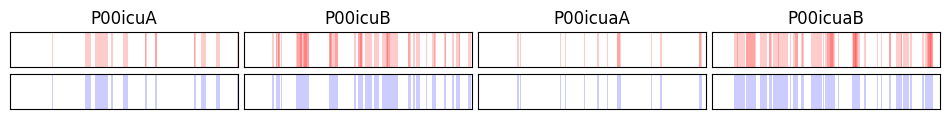

In [4]:
# computes the failure statistics for the system monitoring task
# TODO do this for the other tasks it is interesting to know how much time they spend in failure for different difficulties, plot and record this.

def create_subplots(nrows=2, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,1),
                            gridspec_kw={'width_ratios':[1,1,1,1], 'height_ratios':[1,1], 
                                         'wspace':1/40, 'hspace':0.2})
    for ax in axs.ravel():
        ax.set_xticklabels([])
        ax.set_yticklabels([]) 
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    return fig, axs

fig, axs = create_subplots(nrows=2, ncols=4)
stats = {}
for (k, linedata), ax in zip(datasets.items(), axs.T):
    data = get_system_monitor_task_data(linedata) 
    #print(f"start: {datetime.fromtimestamp(data['start_time'])}, finish: {datetime.fromtimestamp(data['finish_time'])}, duration: {data['finish_time']-data['start_time']:2.0f}s")
    
    ax[0].set_title(k.split(".")[0])
    ax[0].set_xlim(data.start_time, data.finish_time)
    ax[1].set_xlim(data.start_time, data.finish_time)
    
    component_stats = {}
    
    for name, x in data.components.items():
        result = compute_time_intervals(x.failure, x.timestamp, data.start_time, data.finish_time)
        for interval in result.intervals:
            ax[0].axvspan(*interval, alpha=0.2, color='red', linewidth=0)
        component_stats[name] = SimpleNamespace(failure_proportion=result.proportion, 
                                   failure_intervals=result.intervals, 
                                   failure_total=result.binary.sum())
    for interval in merge_intervals([x.failure_intervals for x in component_stats.values()]):
        ax[1].axvspan(*interval, color='blue', linewidth=0, alpha=0.2)
        
    # total failure portion
    failure_proportion = Statistics.compute_failure_proportion([x.failure_intervals for x in component_stats.values()], data.start_time, data.finish_time)
    overlap_failure_proportion = failure_proportion - sum([x.failure_proportion for x in component_stats.values()])
    print(f"{k.split('.')[0]:10}, {failure_proportion:.3f}, {overlap_failure_proportion:.3f}")
    

In [ ]:
# plot target data
def data_tracking_task(data, l2_threshold):
    def failure_l2(x, y, l2_threshold=50): 
        return np.sqrt(x ** 2 + y ** 2) > l2_threshold
    target_data = LineData.findall_from_source(data, TARGET_NAME)
    target_data = LineData.pack_variables(target_data, "timestamp", "x", "y")
    target_data = np.array(target_data)
    fail = failure_l2(target_data[:,1], target_data[:,2], l2_threshold=l2_threshold)    
    return np.concatenate([target_data, fail[:,np.newaxis]], axis=-1)
    
def plot_tracking_task(target_data, ax, ax_prop, l2_threshold, tracking_window_properties, title):
    
    alpha = 0.5
    tracking_window_center = tracking_window_properties['position'] + tracking_window_properties['size']/2
    target_data[:,-3:-1] +=  tracking_window_center # absolute (window) coordinates 
    t,x,y,fail = target_data.T
    
    ax.imshow(img)
    #ax.plot(*(target_data[:,-2:]).T, color="black", alpha=0.1)
    ax.scatter(x,y, marker=".", c=np.array(['blue', 'red'])[fail.astype(int)], alpha=alpha)
    tracking_window_lims = np.stack([tracking_window_properties['position'], tracking_window_properties['position'] + TRACKING_WINDOW_PROPERTIES['size']])
    ax.set_xlim(tracking_window_lims[:,0])
    ax.set_ylim(tracking_window_lims[:,1])
    ax.invert_yaxis()
    ax.set_xticklabels([])
    ax.set_yticklabels([]) 
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_title(title.split(".")[0])
    # valid target locations
    circ = plt.Circle(tracking_window_center, l2_threshold, fill=False, color="blue")
    ax.add_patch(circ)

    ax_prop.set_xlim(0,1)
    ax_prop.set_ylim(0,1)
    ax_prop.set_xticklabels([])
    ax_prop.set_yticklabels([]) 
    ax_prop.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    # fill proportion out of bounds

    prop_fail = fail.sum() / fail.shape[0]
    ax_prop.text(0.02, 0.25, f"{1-prop_fail:.2f}", fontsize=12, color="black")
    ax_prop.text(1-0.25, 0.25, f"{prop_fail:.2f}", fontsize=12, color="black")

    ax_prop.axvspan(0, 1-prop_fail, alpha=alpha, color='blue')
    ax_prop.axvspan(1-prop_fail, 1, alpha=alpha, color='red')
    
def create_subplots(dataset, nrows=1, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,3),
                            gridspec_kw={'width_ratios':[1,1,1,1], 'height_ratios':[10,1], 
                                         'wspace':0.05, 'hspace':-0.3})
    return fig, axs

L2_THRESHOLD = 50 # default for the icua agents

for (par, group) in dataset.items():
    fig, axs = create_subplots(dataset, nrows=2)
    for (k, data), ax in zip(group, axs.T):
        data = data_tracking_task(data, L2_THRESHOLD)
        plot_tracking_task(data, ax[0], ax[1], L2_THRESHOLD, TRACKING_WINDOW_PROPERTIES, k)
        
        # do some other analysis of this data? save it somewhere?
        
        
        
    #plt.savefig(f"./images/tracking/{par}.png", bbox_inches="tight")
    plt.show()
    break
    
    
    
    

In [ ]:

for k, data in itertools.islice(dataset.items(), None):    
    eye_data = LineData.findall_from_source(data, EYETRACKER_NAME)
    eye_data = LineData.pack_variables(eye_data, "timestamp", "label", "x", "y", )
    eye_data = np.array(eye_data)
    sac = eye_data[:,1] == "saccade"
    t, x, y = eye_data[:,0].astype(np.float32), eye_data[:,2].astype(np.float32), eye_data[:,3].astype(np.float32)
    
    fig = plt.figure()
    fig.suptitle(k.split(".")[0])
    plt.imshow(img)
    plt.scatter(x,y, alpha=0.1, marker=".", c=np.array(['black', 'white'])[sac.astype(int)])
    #rect = plt.Rectangle((0,0), *WINDOW_SIZE, fill=False)
    #plt.gca().add_patch(rect)
    plt.gca().set_xlim(0,WINDOW_SIZE[0])
    plt.gca().set_ylim(0,WINDOW_SIZE[1])
    plt.gca().set_aspect("equal")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig("./data/images/" + k.split(".")[0] + ".png", bbox_inches="tight")
    plt.close()


In [ ]:
plt.imshow("./data/background.png")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image using imread()
img = mpimg.imread('./data/background.png')

plt.figure()
# Display the image using imshow()
plt.imshow(img)
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Set limits and ticks for the y-axis
ax.set_ylim(-1.2, 1.2)
ax.set_yticks(np.arange(-1, 1.1, 0.5))

# Draw the filled box outside the y-axis
box_coordinates = np.array([[-2, -10], [-2, 1.2], [0, 1.2], [0, -1.2]])
ax.fill_betweenx(box_coordinates[:, 1], box_coordinates[:, 0], color='lightgray')
print(box_coordinates[:,1])
# Display the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create the plot
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Draw the filled box outside the plot axis below the x-axis
box_coordinates = np.array([[x.min(), ax.get_ylim()[0]], [x.min(), ax.get_ylim()[0]-0.2],
                            [x.max(), ax.get_ylim()[0]-0.2], [x.max(), ax.get_ylim()[0]]])
ax.fill_between(box_coordinates[:, 0], box_coordinates[:, 1], color='lightgray', zorder=-1)

# Display the plot
plt.show()


In [ ]:
x = np.array([0,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,1,0])
y = np.pad(np.logical_xor(x[:-1], x[1:]), (1,0)).astype(int)

yi = np.arange(y.shape[0])[y.astype(bool)]

print(x)
print(y)
print(yi)
print(yi.reshape(yi.shape[0]//2,2))



In [ ]:
def compute_time_in_failure(fail, timestamps, starttime, finishtime):
    fail = np.pad(fail.astype(np.uint8), (1,1)) # pad with zeros either side (ensures even index cardinality)
    timestamps = np.pad(timestamps, (1,1))      # pad with start/end time
    timestamps[0] = starttime
    timestamps[-1] = finishtime
    y = np.pad(np.logical_xor(fail[:-1], fail[1:]), (1,0))
    yi = np.arange(y.shape[0])[y]
    ts = timestamps[yi].reshape(-1,2)
    df = ts[:,1] - ts[:,0]
    return ts, df.sum() / (finishtime - starttime) # failure intervals, proportion of failure
    
   
    
    
    
x = np.array([0,0,1,1,1,0,0,1,1,1,1])
z = np.linspace(0,1,x.shape[0])
plt.figure()
plt.plot(z,x)
plt.scatter(z,x)

ts1, t1 = compute_time_in_failure(x, z, 0.0, 1)

x = np.array([0,0,0,1,0,0,1,1,1,0,0])
z = np.linspace(0,1,x.shape[0])
plt.plot(z,x)
plt.scatter(z,x)

ts2, t2 = compute_time_in_failure(x, z, 0.0, 1)




print(merge_intervals(ts1, ts2))
